# Recurrent Neural Network Model
In this notebook we will describe a recurrent model of orientation selectivity in primary visual cortex as described by [Ben-Yishai et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC42058/pdf/pnas01493-0220.pdf). Here a network of neurons is described by the following equation:

\begin{equation}
\tau \frac{dr(\theta)}{dt} =-r(\theta) F(I(\theta)
\end{equation}

where $r(\theta)$ is the firing rate of a neuron with preferred orientation $\theta$ between $−\pi/2$ and $+\pi/2$. $\tau = 10 ms$ is a time constant; $I(\theta)$ is the input it receives, and $F(I)$ is the input-output relationship (f−I curve). We will use a simple threshold linear $F(I) = [I]_+$, which is zero if $I < 0$, and $I$ if $I > 0$. The input is the sum of an external (thalamic) input h(θ) and a recurrent input,

\begin{equation}
I(\theta) = h(\theta) + \int_{−\pi/2}^{+\pi/2} \frac{d\theta'}{\pi} (J_0 + J_2 \cos (2(\theta - \theta'))) r(\theta')
\end{equation}

The thalamic input $h(θ) = Ac(1 − \epsilon + \epsilon \cos(2(\theta − \theta_{cue}))$ where $\theta_{cue}$ is the peak of thalamic input assumed to be at the center of the network, $\theta_{cue}= 0$. The parameter $\epsilon$ expresses the tuning of the thalamic input, $c$ is the contrast, and $A$ is the amplitude.

In [19]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from pylab import rcParams
from matplotlib.ticker import FormatStrFormatter
rcParams['figure.figsize'] = 15, 5

# Define RNN object

In [27]:
class RNN_model:
    def __init__(self, n = 100, tau = 10):
        self.n = n                                                 # number of Neurons
        self.N = np.arange(self.n)                                 # neuron array
        self.N_theta = np.linspace(-math.pi/2, math.pi/2, self.n)  # preferred orientation tuning
        self.tau = tau                                             # time constant in ms
        
    def thalamic_input(self, A, c, e, theta_cue = 0):
        h = A * c *(1 - e + e * np.cos( 2 * ( (-math.pi/2) + (math.pi*self.N / self.n) - theta_cue) ))
        return h
    
    def recurrent_connections(self, Jo, J2):
        W = (Jo + J2 * np.cos( 2 * np.array([self.N_theta - i for i in self.N_theta]) ))/ self.n
        return W
        
    def simulation(self, h, W, T, alpha, thetao, noise_flag = 0, sig = 3):
        dt = T[1] - T[0]
        r = alpha * np.cos(2* (self.N_theta - thetao)) # initial firing rate
        R = []

        for t in T:
            if noise_flag == 1: 
                I = np.array([ h[i] + np.sqrt(dt)*np.random.rand(1)[0]*sig + W[i].dot(r) for i in range(len(h))])
            else:
                I = np.array([ h[i] + W[i].dot(r) for i in range(len(h)) ])
            I[np.where(I<0)] = 0
            r = r + dt * ( -r + I ) / self.tau
            R.append(r)

        R = np.array(R)  
        return R
    
    def run_plot(self, T, jc, JC, A, e, Jo, alpha, thetao, flag = 'c', plot_N =50, noise_flag=0, sig = 3):
        plt.subplot(141)
        ax1 = plt.subplot(1, 4, 1)
        ax2 = plt.subplot(1, 4, 2)
        ax3 = plt.subplot(1, 4, 3)
        ax4 = plt.subplot(1, 4, 4)
        cmap = plt.get_cmap("tab10")
        cc = 0
        
        for i in JC:
            if flag == 'c':
                h = self.thalamic_input(A , c = i, e = e)
                W = self.recurrent_connections(Jo , jc)
            elif flag == 'j':
                h = self.thalamic_input(A , c = jc, e = e)
                W = self.recurrent_connections(Jo , i)
            R = self.simulation(h, W, T, alpha, thetao, noise_flag, sig)

            ax1.plot(self.N_theta, R[-1,:], c= cmap(cc), lw =3)
            ax1.plot(self.N_theta, R[0, :], c= cmap(cc), lw =3, alpha=.75, ls='--')
            ax2.plot(T, R[:, plot_N], lw =3)
            ax3.plot(self.N_theta, W[:, plot_N]*self.n, c= cmap(cc), lw =3)
            ax4.plot(self.N_theta, h, c= cmap(cc), lw =3)
            cc +=1
            
        ax1.set_xlabel('orientation (deg.)')
        ax1.set_ylabel('firing rate (Hz)')
        ax2.set_xlabel('time')
        ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax3.set_ylabel('norm W input')
        ax3.axhline(Jo, color='black', lw=2, ls='--')
        ax3.set_xlabel('orientation (deg.)')
        ax4.set_ylabel('h input')
        ax4.set_xlabel('orientation (deg.)')
        ax4.plot([], [], color='k', ls='--', lw= 2)
            
        if flag == 'c':
            leg = ['contrast '+str(i) for i in JC]
        elif flag == 'j':
            leg = ['J_2 '+str(i) for i in JC]
        leg.append('initial cond.')
        plt.legend(leg, bbox_to_anchor=(1, 1))

# Simulations
We will implement an instance of this network with 50 neurons $N$ whose preferred orientation tuning tiles the space uniformelly. Neurons are labeled as $\theta_i = (\pi/N)i - \pi/2$, $i = 1,2,..., N$. We will initiate the network with firing rates $r(\theta_i, t=0) = \alpha \cos (2(\theta - \theta_0))$ with $\alpha = 2$ or $5$ Hz and $\theta_0 = 0$ or $\pi/4$.

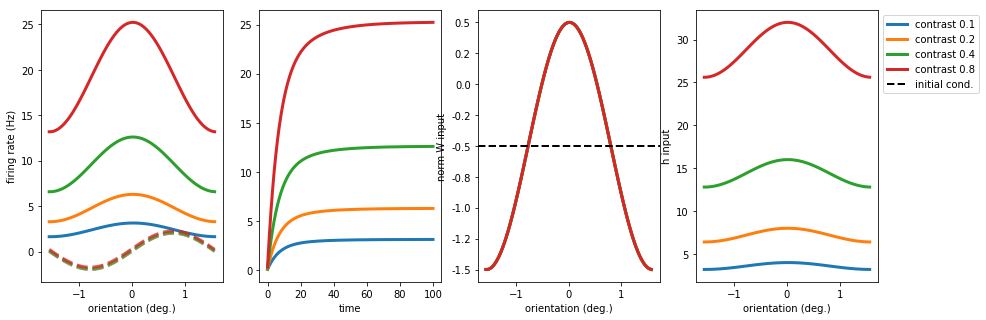

In [29]:
# 1)
T = np.linspace(0, 100, 1000)
C = np.array([.1, .2, .4, .8])
alpha = 2
A = 40
e = .1
Jo = -.5
J2 = 1
thetao = math.pi/4

RNN = RNN_model()
RNN.run_plot(T, J2, C, A, e, Jo, alpha, thetao, flag = 'c')

Starting from the left, the first figure shows the activity profile of the network at steady state (solid lines) and initial conditions (dashed lines). This function also representes the tuning curve of a neuron centered at its preferred orientation. In this graph we see that the distribution of firing rates is bell shaped. Also, we see that the network evolves from its initial state to steady state around the input tuninig. We also observe that the overall firing rate of the network scales with the contrast. 

The second figure shows the activity of an example neuron of the network over time, where we see that the firing rate evolves quickly and then plateaus when the network is tuned to the input.

We can also see the effect of contrast in the recurrent connectivity (figure 3) and the input (4th figure). Here, the increase in contrast scales the thalamic input but has no effect on the recurrent connectivity.

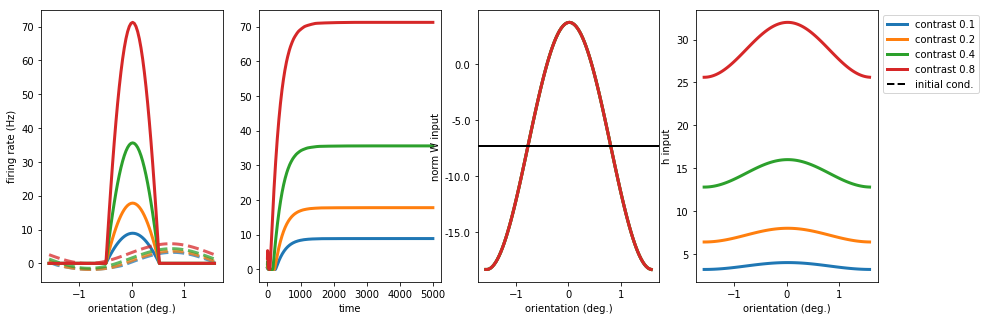

In [22]:
# 2)
T = np.linspace(0, 5000, 5000)
C = np.array([.1, .2, .4, .8])
alpha = 2
A = 40
e = .1
Jo = -7.3
J2 = 11
thetao = math.pi/4

RNN = RNN_model()
RNN.run_plot(T, J2, C, A, e, Jo, alpha, thetao, flag = 'c')

In this simulation, compared to the previous one, we have scaled the strength of the recurrent connectivity. This results in a narrower activity profile at the level of the network (left figure). This can be interpreted as an increase in both excitatory and inhibitory connections, and thus neurons whose preferred orientation aligns with the input stimulus are going to be even greaterly activated and those that aren't are going to be strongly inhibited or completely silenced like in the simulation above.

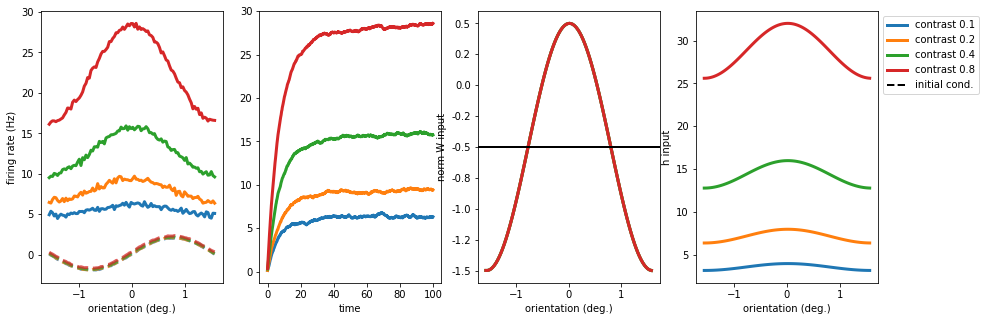

In [23]:
# 3)
T = np.linspace(0, 100, 1000)
C = np.array([.1, .2, .4, .8])
alpha = 2
A = 40
e = .1
Jo = -.5
J2 = 1
thetao = math.pi/4

RNN = RNN_model()
RNN.run_plot(T, J2, C, A, e, Jo, alpha, thetao, flag = 'c', noise_flag =1, sig =30)

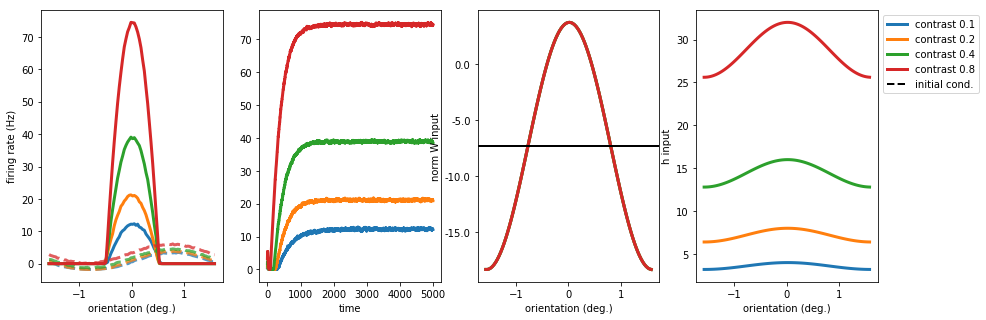

In [24]:
# 3)
T = np.linspace(0, 5000, 5000)
C = np.array([.1, .2, .4, .8])
alpha = 2
A = 40
e = .1
Jo = -7.3
J2 = 11
thetao = math.pi/4

RNN = RNN_model()
RNN.run_plot(T, J2, C, A, e, Jo, alpha, thetao, flag = 'c', noise_flag =1)

In these simulations we included observational noise drawn from a Gaussian distribution and added to the sensory input. If we compare the two simulations we see that the effect of the noise is grater in the first simulation than the later one. This is due to the relevative relevance of the two inputs (recurrent connectivity and thalamic/sensory input). In the first simualtion the thamic input plays a larger role and thus is more affected by the noise added to it. In the second one the recurrent connectivity governs the behavior of the network and is thus less affected by the noise.

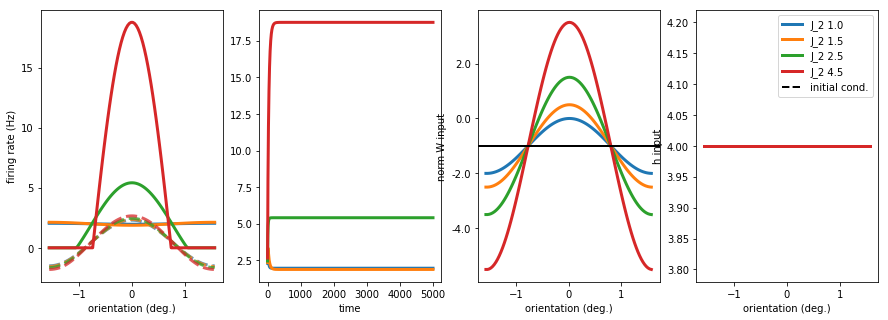

In [25]:
# 4)
T = np.linspace(0, 5000, 5000)
Js = np.array([1, 1.5, 2.5, 4.5])
c = .1
alpha = 2
A = 40
e = 0
Jo = -1

RNN = RNN_model()
RNN.run_plot(T, c, Js, A, e, Jo, alpha, thetao=0, flag = 'j', noise_flag =0)

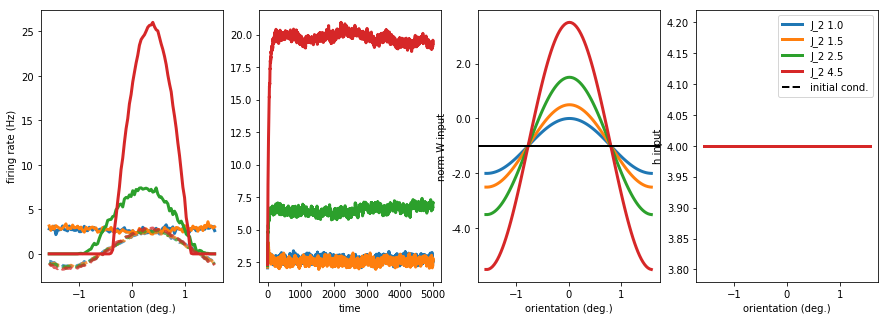

In [26]:
# 4)
T = np.linspace(0, 5000, 5000)
Js = np.array([1, 1.5, 2.5, 4.5])
c = .1
alpha = 2
A = 40
e = 0
Jo = -1
thetao = math.pi/4

RNN = RNN_model()
RNN.run_plot(T, c, Js, A, e, Jo, alpha, thetao=.35, flag = 'j', noise_flag =1)

If we untune the thalamic input by setting $\epsilon$ to zero. The network will form bell-shape attarctors when the recurrent connectivity is high enough. If not the levels of activity will be almost uniform (slight desinhibition). However, even when the recurrent connectivity is high enough to form such attractors, they are formed at the orientation where the initial condiction was tuned. 